In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, SimpleRNN
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.metrics import mean_absolute_error as mae
from pandas.tseries.offsets import BDay

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14494480343520806349
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11320098816
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1229225032833911937
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
 xla_global_id: 416903419]

In [3]:
df_main = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Stock Market/RELIANCE.csv')
df_main.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,RELIANCE,EQ,233.05,237.50,251.70,237.50,251.70,251.70,249.37,4456424,1.111319e+14,NaN,NaN,NaN
1,2000-01-04,RELIANCE,EQ,251.70,258.40,271.85,251.30,271.85,271.85,263.52,9487878,2.500222e+14,NaN,NaN,NaN
2,2000-01-05,RELIANCE,EQ,271.85,256.65,287.90,256.65,286.75,282.50,274.79,26833684,7.373697e+14,NaN,NaN,NaN
3,2000-01-06,RELIANCE,EQ,282.50,289.00,300.70,289.00,293.50,294.35,295.45,15682286,4.633254e+14,NaN,NaN,NaN
4,2000-01-07,RELIANCE,EQ,294.35,295.00,317.90,293.00,314.50,314.55,308.91,19870977,6.138388e+14,NaN,NaN,NaN


In [4]:
df_main.drop(['Trades','Deliverable Volume','%Deliverble'],axis=1,inplace=True)

In [5]:
df_main.shape

(5306, 12)

In [6]:
time = pd.date_range(start='2000-01-03',periods=5306,freq=BDay())
df_main['time_stamp'] = pd.DataFrame(time)
df_main.drop(['Date'],axis=1,inplace=True)
df_main = df_main.set_index('time_stamp')

In [ ]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5306 entries, 2000-01-03 to 2020-05-04
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Symbol      5306 non-null   object 
 1   Series      5306 non-null   object 
 2   Prev Close  5306 non-null   float64
 3   Open        5306 non-null   float64
 4   High        5306 non-null   float64
 5   Low         5306 non-null   float64
 6   Last        5306 non-null   float64
 7   Close       5306 non-null   float64
 8   VWAP        5306 non-null   float64
 9   Volume      5306 non-null   int64  
 10  Turnover    5306 non-null   float64
dtypes: float64(8), int64(1), object(2)
memory usage: 497.4+ KB


In [7]:
df = df_main[['Close']]

In [8]:
df.head()

,Close
time_stamp,
2000-01-03,251.70
2000-01-04,271.85
2000-01-05,282.50
2000-01-06,294.35
2000-01-07,314.55


In [ ]:
df.tail()

,Close
time_stamp,
2020-04-28,1937.85
2020-04-29,1988.65
2020-04-30,1997.30
2020-05-01,2024.05
2020-05-04,1994.50


In [9]:
plt.rcParams['figure.figsize'] = [15,8]

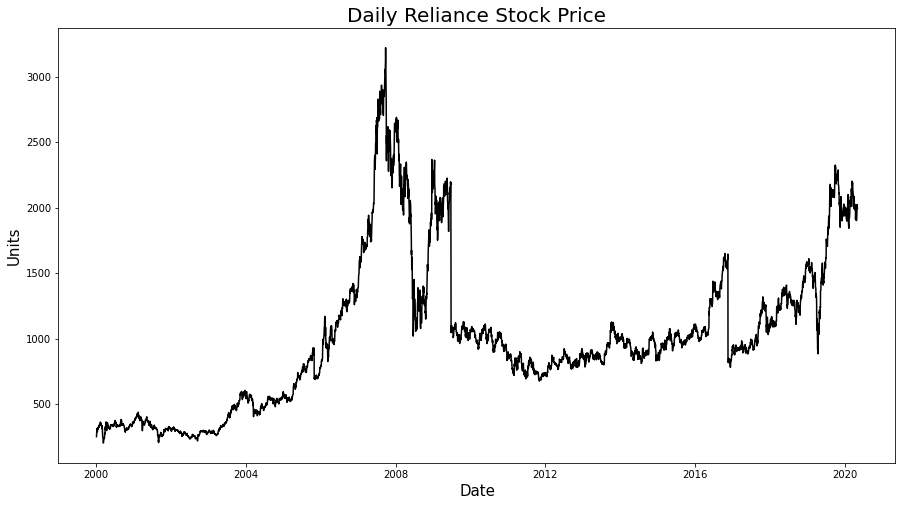

In [10]:
plt.plot(df,color='black')
plt.title('Daily Reliance Stock Price',fontsize=20)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Units',fontsize=15)
plt.show()

In [13]:
def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X.append(data_arr[i:d,0])
        Y.append(data_arr[d,0])
    return np.array(X), np.array(Y)

In [34]:
from sklearn.preprocessing import MinMaxScaler
#create numpy.ndarray 
df['Close'] = df['Close'].astype(np.float32)
df_arr = df.values
df_arr = np.reshape(df_arr, (-1, 1))
scaler = MinMaxScaler(feature_range=(0.1, 1))
df_arr = scaler.fit_transform(df_arr)

In [35]:
#Split data set into testing dataset and train dataset
train_size = 4775
train, test =df_arr[0:train_size,:], df_arr[train_size:len(df_arr),:]
# setup look_back window 
look_back = 4
#convert dataset into right shape in order to input into the DNN
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)
# reshape input to be [samples, window size, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(4771, 1, 4)
(4771,)
(527, 1, 4)
(527,)


In [16]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 133 kB 8.1 MB/s 


In [ ]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,SimpleRNN
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt

In [ ]:
def build_model(hp):
    model = keras.Sequential()
    model.add(LSTM(hp.Int('lstm_layer_1',min_value=8,max_value=256,step=8), activation="relu", input_shape=(1,look_back),recurrent_dropout = hp.Choice("recurrent_dropout",[0.2,0.3,0.4],default=0.2)))
    model.add(Dense(hp.Int('dense_layer_1',min_value=8,max_value=256,step=8),activation="relu"))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
             hp.Float('learning_rate', min_value=1e-3, max_value=1e-1, sampling="log")),
        loss='mape',
        metrics=['mape'])
    return model

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_mape',
    max_trials=10,
    executions_per_trial=1,
    directory='project',
    project_name='loa_em_4')

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
lstm_layer_1 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 256, 'step': 8, 'sampling': None}
recurrent_dropout (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.3, 0.4], 'ordered': True}
dense_layer_1 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 256, 'step': 8, 'sampling': None}
Dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [ ]:
tuner.search(trainX, trainY,
             epochs=200,
             batch_size=35,
             validation_data=(testX, testY)) 

Trial 10 Complete [00h 02m 24s]
val_mape: 1.4890766143798828

Best val_mape So Far: 1.4428285360336304
Total elapsed time: 00h 36m 18s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in project/loa_em_4
Showing 10 best trials
Objective(name='val_mape', direction='min')
Trial summary
Hyperparameters:
lstm_layer_1: 104
recurrent_dropout: 0.4
dense_layer_1: 104
Dropout_rate: 0.1
learning_rate: 0.0017011092817375538
Score: 1.4428285360336304
Trial summary
Hyperparameters:
lstm_layer_1: 184
recurrent_dropout: 0.3
dense_layer_1: 192
Dropout_rate: 0.2
learning_rate: 0.0011616898171829461
Score: 1.4454517364501953
Trial summary
Hyperparameters:
lstm_layer_1: 224
recurrent_dropout: 0.2
dense_layer_1: 208
Dropout_rate: 0.0
learning_rate: 0.06461395303882178
Score: 1.449363112449646
Trial summary
Hyperparameters:
lstm_layer_1: 120
recurrent_dropout: 0.2
dense_layer_1: 248
Dropout_rate: 0.4
learning_rate: 0.00269263370697111
Score: 1.4511526823043823
Trial summary
Hyperparameters:
lstm_layer_1: 24
recurrent_dropout: 0.2
dense_layer_1: 160
Dropout_rate: 0.2
learning_rate: 0.001372259330713521
Score: 1.4558237791061401
Trial summary
Hyperparameters:
lstm_

In [ ]:
from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 4))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 104)               45344     
                                                                 
 dense (Dense)               (None, 104)               10920     
                                                                 
 dropout (Dropout)           (None, 104)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 105       
                                                                 
Total params: 56,369
Trainable params: 56,369
Non-trainable params: 0
_________________________________________________________________


In [19]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Bidirectional

In [39]:
model = Sequential()
model.add(LSTM(16,activation='relu',input_dim = 4,return_sequences=True))
model.add(LSTM(8,activation='relu'))
model.add(Dense(1,activation='linear'))
ad=optimizers.Adam(learning_rate = 0.000017011092817375538)
model.compile(optimizer = ad, loss = 'mape', metrics = ['mape'])
model_history=model.fit(trainX, trainY,validation_data=(testX,testY), batch_size = 35, epochs = 800)

Epoch 1/800
137/137 [==============================] - 52s 346ms/step - loss: 99.3569 - mape: 99.3569 - val_loss: 99.2597 - val_mape: 99.2597
Epoch 2/800
137/137 [==============================] - 0s 3ms/step - loss: 97.9370 - mape: 97.9370 - val_loss: 98.5158 - val_mape: 98.5158
Epoch 3/800
137/137 [==============================] - 0s 3ms/step - loss: 96.6242 - mape: 96.6242 - val_loss: 97.8163 - val_mape: 97.8163
Epoch 4/800
137/137 [==============================] - 0s 3ms/step - loss: 95.3291 - mape: 95.3291 - val_loss: 97.1222 - val_mape: 97.1222
Epoch 5/800
137/137 [==============================] - 0s 3ms/step - loss: 94.0291 - mape: 94.0291 - val_loss: 96.4237 - val_mape: 96.4237
Epoch 6/800
137/137 [==============================] - 0s 3ms/step - loss: 92.7175 - mape: 92.7175 - val_loss: 95.7184 - val_mape: 95.7184
Epoch 7/800
137/137 [==============================] - 0s 3ms/step - loss: 91.3929 - mape: 91.3929 - val_loss: 95.0030 - val_mape: 95.0030
Epoch 8/800
137/137 [===

In [21]:
def model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

In [40]:
train_score = model.evaluate(trainX, trainY,verbose=0)
test_score = model.evaluate(testX, testY,verbose=0)

Train MAPE : 1.65 
Test MAPE : 1.75 


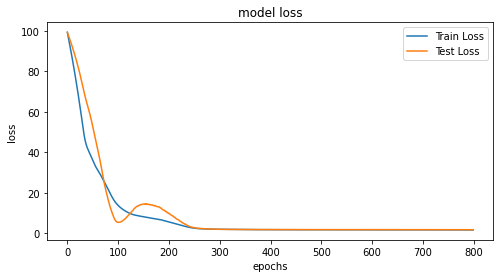

In [41]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
trainY = scaler.inverse_transform([trainY])
test_predict = scaler.inverse_transform(test_predict)
testY = scaler.inverse_transform([testY])
print('Train MAPE : %.2f ' % (train_score[1]))
print('Test MAPE : %.2f ' % (test_score[1]))
model_loss(model_history)

In [24]:
import seaborn as sns

In [25]:
def prediction_plot(testY, test_predict,look_back):
    len_prediction=[x for x in range(4771,5298)]
    plt.plot(trainY.reshape(-1,))
    plt.plot(len_prediction, testY.reshape(-1,), marker='.', label='actual')
    plt.plot(len_prediction, test_predict, 'g', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Units', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show()

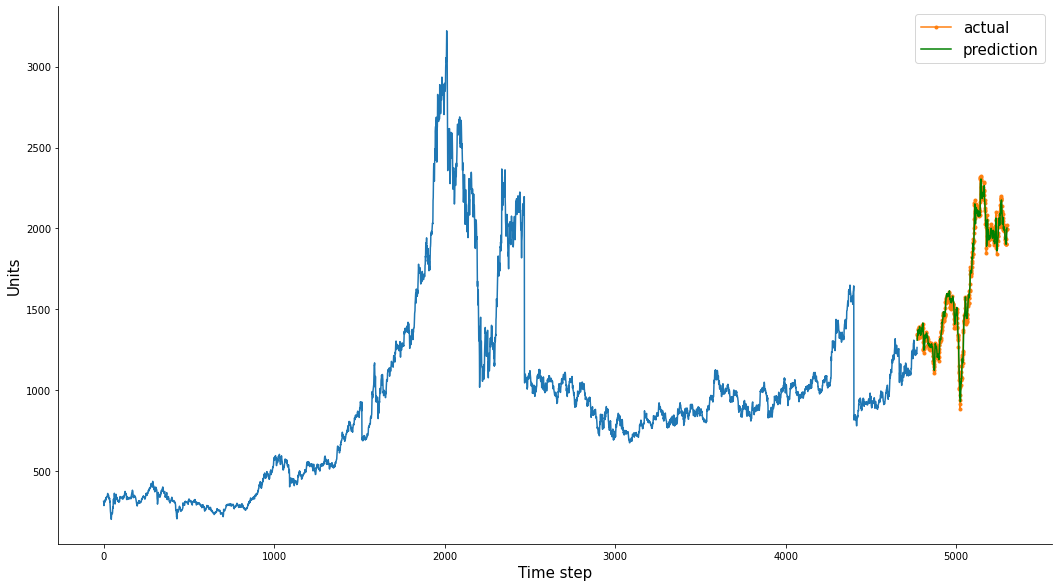

In [42]:
test_predict = model.predict(testX)
test_predict = scaler.inverse_transform(test_predict)
prediction_plot(testY, test_predict,look_back)